# Модель предсказания возрастной группы по данным о поведении анонимного пользователя в цифровой среде

Заказчик - крупная IT-компания «Йети», управляющей группой популярных интернет-сервисов. Значительную часть дохода компания получает от контекстной рекламы. Алгоритмы рекламной сети «Йети» (РСЙ) используют демографический таргетинг, включая возрастной, по данным, которые собирают данные через технологию, анализирующую поведение пользователей без прямого доступа к их паспортным данным.

Возрастной таргетинг важен, поскольку компания хочет выходить на корректную целевую аудиторию каждого объявления. При ошибке показа таргетированной рекламы в рамках возрастной группы маркетинговая кампания с большой вероятностью провалится, конверсия компании упадёт, компания понесёт прямые финансовые убытки, а пользователи будут недовольны ненужными объявлениями.

Задача заключается в построении модели многоклассовой классификации, предсказывающей возрастную категорию пользователей на основании логов посещений сайтов, хранящих информацию о категориях посещённых сайтов, а также частоте и времени таких посещений. Модель нужно оценить одинаково по всем классам, даже если один из них встречается редко, поэтому предлагается использовать макро-усреднение. Значение F1-меры лучшей модели должно быть не меньше 0.75 и на кросс-валидации по обучающей выборке, и на тестовой выборке.

## Подготовка среды и библиотек

### Импорт бибилиотек

In [1]:
!pip install phik -U -q
!pip install scikit-learn==1.6.1 -q

In [2]:
#import sklearn
#print(sklearn.__version__)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from functools import reduce
#from datetime import datetime

from phik import phik_matrix

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    TargetEncoder,
    FunctionTransformer,
    StandardScaler,
    MinMaxScaler)

from sklearn.feature_selection import VarianceThreshold, RFE

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold,
    GridSearchCV )

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    classification_report )

from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

from sklearn.frozen import FrozenEstimator

import joblib
from datetime import datetime

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Глобальные константы

In [5]:
RANDOM_SEED=189
#RANDOM_SEED=42
MODEL_VERSION=1.0
TEST_SIZE=0.2

## Загрузка данных

Данные представлены в шести разных csv-файлах. Загрузим их и проведём поверхностный осмотр, для составления первого впечатления. Для каждого файла выведем общую информацию и первые несколько строк для визуального контроля соответствия данных декларированному заказчиком смысловому наполнению. Дополним эту информацию описанием данных, предоставленную заказчиком.

### Функция загрузки

Для унификации процесса загрузки в связи с тем, что данные выбираются из разных файлов, один из которых к тому же достаточно объёмен (лог посещений - 100 Мб), а также с учётом того, что размещение файлов может быть изменено, создадим блок, который будет декларировать все нужные датафреймы и функцию, которая их загрузит.

In [6]:
def load_data():
    global df_users
    global df_visits
    global df_activity
    global df_surf_depth
    global df_primary_device
    global df_cloud_usage
    
    df_users = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_users.csv ')

    df_visits = pd.DataFrame()
    try:
        df_visits = pd.read_csv('ds_s13_visits.csv ')
    except:
        try:
            df_visits = pd.read_csv('datasets/ds_s13_visits.csv ')
        except:
            df_visits = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_visits.csv ')

    df_activity = pd.read_csv('https://code.s3.yandex.net/datasets/ads_activity.csv ')
    df_surf_depth = pd.read_csv('https://code.s3.yandex.net/datasets/surf_depth.csv ')
    df_primary_device = pd.read_csv('https://code.s3.yandex.net/datasets/primary_device.csv ')
    df_cloud_usage = pd.read_csv('https://code.s3.yandex.net/datasets/cloud_usage.csv ')

load_data()

### Данные пользователей

In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5913 non-null   object
 1   age_category  5913 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.5+ KB


In [8]:
df_users.head()

,user_id,age_category
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2
2,678b-614cd47d854b9d591db2-000b2e50,0
3,4ac0-dad169100b4a29b20818-b26ae7c5,4
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0


Таблица содержит информацию о возрастной категории пользователя:
* user_id — уникальный идентификатор пользователя.
* age_category — возрастная категория пользователя, содержит следующие категории:
  * 0: младше 18;
  * 1: 18-25 лет;
  * 2: 26-40 лет;
  * 3: 41-55 лет;
  * 4: 56+ лет.

### Данные посещений

In [9]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065745 entries, 0 to 1065744
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   date              1065745 non-null  object
 1   daytime           1065745 non-null  object
 2   session_id        1065745 non-null  object
 3   user_id           1065745 non-null  object
 4   website_category  1065745 non-null  object
dtypes: object(5)
memory usage: 40.7+ MB


In [10]:
df_visits.head()

,date,daytime,session_id,user_id,website_category
0,2025-11-01,вечер,066e4e02-8c1f-45eb-a50f-178659abe698,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 17
1,2025-11-01,вечер,0bce1749-3376-439c-9a22-f8ffbba00e9a,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 19
2,2025-11-01,вечер,3445d8c4-221d-4d88-bb6a-a2939fe3c610,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 18
3,2025-11-01,вечер,3bf97286-1d91-4aaa-af4a-ed58eceb8cd2,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 20
4,2025-11-01,вечер,40e22712-3cad-410d-a9f0-13bd8f6911c0,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 05


Лог посещений сайтов с анонимизацией URL путём замены на анонимизированную категорию сайта, также вместо точного времени используется время суток.

Признаки в датасете:
* date — дата посещения сайта.
* daytime — анонимизированное время посещения сайта. Категории:
   * утро,
   * день,
   * вечер,
   * ночь.
* session_id — уникальный идентификатор сессии, сессия — это последовательность действий пользователя на сайте, которая начинается при первом взаимодействии с ресурсом и завершается по правилам тайм-аута или смены условий.
* user_id — уникальный идентификатор пользователя.
* website_category — анонимизированная категория сайта, в лог включены несколько десятков категорий, которые позволяют эффективно сегментировать аудиторию, что позволяет сократить пространство признаков модели без потери её качества.

### Данные взаимодействия пользователя с рекламными объявлениями

In [11]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5826 non-null   object
 1   ads_activity  5826 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB


In [12]:
df_activity.head()

,user_id,ads_activity
0,e318-d8e69c86b543a5fb927c-c36fb6e6,очень часто
1,35cd-a972339dec534f49332c-a8b6d383,редко
2,f7e6-3b29cf9cb7ed4bb00d8f-81534360,очень редко
3,5186-e25a37549e50f45b2b43-178eaabe,умеренно
4,febd-077f277466253ee04ef6-42656680,умеренно


Активность взаимодействия пользователя с рекламными объявлениями:
* user_id — уникальный идентификатор пользователя.
* ads_activity — характеристика CTR (Click-Through Rate — показатель кликабельности), выраженная одним из значений:
  * очень редко,
  * редко,
  * умеренно,
  * часто,
  * очень часто.

### Данные глубины перехода по сайтам во время одной сессии

In [13]:
df_surf_depth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     5715 non-null   object
 1   surf_depth  5715 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB


In [14]:
df_surf_depth.head()

,user_id,surf_depth
0,f238-0c4c1e787cce311541b7-736925a0,поверхностно
1,9030-1b562ad80182b6dc27f1-ce811740,глубоко
2,22e0-7c6cadcc45e246b8688d-c43c9b23,поверхностно
3,9d7f-a19f10756378940a49b5-5d03e1ef,поверхностно
4,4233-bb5ae4b09827e5497094-1a4956af,глубоко


В таблице содержится два признака:
* user_id — уникальный идентификатор пользователя
* surf_depth — категориальная переменная, характеризующая глубину перехода пользователя по сайтам во время одной сессии. Содержит категории
  * поверхностно,
  * средне,
  * глубоко.

### Данные о типе основного устройства пользователя для выхода в Интернет

In [15]:
df_primary_device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         5669 non-null   object
 1   primary_device  5669 non-null   object
dtypes: object(2)
memory usage: 88.7+ KB


In [16]:
df_primary_device.head()

,user_id,primary_device
0,d602-ec060db7597a6b8cd4e7-aa625896,смартфон
1,9204-9558455be649d4e77945-b5e25d62,ПК
2,5eea-22babd6a9474b43b9d0b-a39a4cf2,ноутбук
3,c142-0296948e8d08e417de10-2da9523c,смартфон
4,abec-bb4092da51eb2233a928-e44ba074,ПК


Таблица содержит два признака:
* user_id — уникальный идентификатор пользователя.
* primary_device — информация о типе основного устройства пользователя для выхода в Интернет.

### Данные об использовании облачных технологий

In [17]:
df_cloud_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      5680 non-null   object
 1   cloud_usage  5680 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.1+ KB


In [18]:
df_cloud_usage.head()

,user_id,cloud_usage
0,a1e4-91c8a52eb855595e653f-298ce305,False
1,db9a-7b8e9e94448b7fcb19b6-4edca15f,False
2,0d55-9ad768879e9b08ca7ff9-843f76c7,True
3,4baa-43285d10a6d3cc969f2a-b21881d1,False
4,b8cd-cbb2411db005115ca64d-32700c62,False


Использование облачных технологий:
* user_id — уникальный идентификатор пользователя;
* cloud_usage — True означает, что пользователь обращается к облачным ресурсам типа Яндекс 360 прямо или через посещаемые сайты.

## Объединение данных

На первый взгляд загрузка прошла корректно: структура и содержимое датафреймов исходных данных соответствуют декларированному заказчиком описанию. С учётом того, что в каждом из файлов присутствует идентификатор пользователя, позволяющий связать данные в один массив, можно рассматривать комбинацию файлов как набор связанных таблиц реляционной БД. Для продолжения работы требуется объединить данные из разных файлов в один датафрейм, чтобы создать витрину профиля пользователя.

### Объединение базовых признаков

При объединении данных важно учитывать, что в пяти из шести файлов данных фактически собраны блоки, описывающие какой-то один характерный признак пользователя, связь выполняется по идентификатору, поэтому возрастные данные пользователей (признак `age_category`, фактически - целевая переменная), данные взаимодействия пользователя с рекламными объявлениями (признак `ads_activity`), данные глубины перехода по сайтам во время одной сессии (признак `surf_depth`), данные о типе основного устройства пользователя (признак `primary_device`) и данные об использовании облачных технологий (признак `cloud_usage`) в витрине профиля появятся "как есть", т.е. мы выполним объединение этих датасетов по признаку `user_id`, после чего создадим ряд комбинированных признаков на основании данных посещений сайтов.

В связи с тем, что данные пользователей, содержащие целевую переменную  послужат основой витрины данных пользователя, предлагается сразу проверить наличие пропусков в значениях целевой переменной и дубликатов.

In [19]:
df_users.isna().sum()

user_id         0
age_category    0
dtype: int64

In [20]:
df_users.duplicated().sum()

np.int64(87)

Несмотря на отсутствие пропусков, в данных возрастных категорий пользователей найденo 87 полных дубликатов, необходимо избавиться от них до начала объединения с признаками из других файлов.

In [21]:
df_users = df_users.drop_duplicates()
df_users.duplicated().sum()

np.int64(0)

In [22]:
df_users.shape

(5826, 2)

Для получения промежуточного состояния витрины профилей объединим датафреймы, содержащие данные отдельных признаков.

Очевидно, что нас интересуют только данные пользователей, для которых известно значение целевой переменной, т.е. обязательно должна присутствовать запись в датасете данных пользователей - ранее мы убедились, что пропусков в значениях целевой переменной и дубликатов в датафрейме df_users нет, поэтому объединение будем выполнять по принципу how='left' - аналогу LEFT OUTER JOIN в SQL, начиная с данных профилей и последовательно перебирая справочники с дополнительными признаками.

In [23]:
df_list = [df_users, df_activity, df_surf_depth, df_primary_device, df_cloud_usage]

In [24]:
df = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='left'), df_list)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6059 entries, 0 to 6058
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         6059 non-null   object
 1   age_category    6059 non-null   int64 
 2   ads_activity    5826 non-null   object
 3   surf_depth      5943 non-null   object
 4   primary_device  5899 non-null   object
 5   cloud_usage     5909 non-null   object
dtypes: int64(1), object(5)
memory usage: 284.1+ KB


В результате объединения данных был получен датафрейм с количеством строк большим нежели размерность исходного датасета с возрастными категориями пользователей, такое могло произойти в случае, если в одном из присоединямых справа датафреймов записи для одного и того же пользователя встречались более одного раза. Проверим эту гипотезу.

In [26]:
#df[df.duplicated(keep=False)].sort_values(by='user_id')
df[df.duplicated()].sort_values(by='user_id')

,user_id,age_category,ads_activity,surf_depth,primary_device,cloud_usage
448,0259-a9907d16efbe00c4e18a-ce0364c9,1,очень часто,глубоко,смартфон,True
329,02d4-8707e8f46c6769731dd5-c268adff,4,очень редко,поверхностно,планшет,False
1108,0501-ba75c2755d55061a096d-d0e8c7db,2,часто,средне,ПК,True
2187,085f-12567fc9227eabf8725a-eee1af8d,4,редко,поверхностно,ПК,False
5356,0aac-a5fada325b7e17621d1a-9df56d7e,4,очень редко,средне,смартфон,False
...,...,...,...,...,...,...
638,fae7-9299db9dc58cb91d8120-21a9b92d,2,часто,средне,смартфон,False
3887,fafb-ce4d839b08c1b25eced1-77725b26,1,редко,средне,смартфон,True
3800,fb05-8a3b260e43f8cd2121b2-3ce15903,0,редко,глубоко,планшет,True
5489,fc4b-62b0fec3c90fb70f98f1-5e606a7c,3,очень редко,поверхностно,смартфон,False


Действительно, по завершении объединения данных найдено 233 полных дубликата, если вычесть это значение из размерности датафрейма 6059, то получим как раз размерность исходного датафрейма df_users. Удалим дубликаты для получения уникальных записей по каждому `user_id`.

In [27]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [28]:
print(df.shape)
df.head()

(5826, 6)


,user_id,age_category,ads_activity,surf_depth,primary_device,cloud_usage
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4,NaN,глубоко,смартфон,False
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2,умеренно,средне,смартфон,False
2,678b-614cd47d854b9d591db2-000b2e50,0,умеренно,средне,смартфон,False
3,4ac0-dad169100b4a29b20818-b26ae7c5,4,редко,поверхностно,смартфон,True
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0,очень редко,поверхностно,смартфон,True


### Создание комбинированных признаков

Сам по себе лог посещения сайтов предоставляет собой перечень записей о сетевой активности пользователя размерностью более миллиона строк и при прямом объединении с детальными характеристиками пользователей превратит витрину профилей в набор бессистемных событий, дополненных данными пользователя, но при этом не несущих особой смысловой нагрузки, поэтому на таких данных, даже если отбросить необходимость использования немалых вычислительных мощностей для обработки этого массива, модели по сути не на чем будет обучаться. Для корректного использования этих данных нужно использовать лог посещений для создания некоторого количества комбинированных признаков.

In [29]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065745 entries, 0 to 1065744
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   date              1065745 non-null  object
 1   daytime           1065745 non-null  object
 2   session_id        1065745 non-null  object
 3   user_id           1065745 non-null  object
 4   website_category  1065745 non-null  object
dtypes: object(5)
memory usage: 40.7+ MB


#### Преобразование даты

Рассмотрим возможные значения дат, чтобы понять за какой временной диапазон представлены данные посещений и как можно использовать этот признак.

In [30]:
df_visits['date'].unique()

array(['2025-11-01', '2025-11-02', '2025-11-03', '2025-11-04',
       '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08',
       '2025-11-09', '2025-11-10', '2025-11-11', '2025-11-12',
       '2025-11-13', '2025-11-14'], dtype=object)

Из списка уникальных значений видно, что список дат ограничен всего лишь 14 числами ноября 2025 года, то есть никакой информации о, например, сезонности событий получить из этих значений не получится. Однако, данные за две недели дают достаточно репрезентативную выборку, позволяющую группировать события по дням недели и, таким образом, отслеживать изменение активности, например, отдельно в рабочие и выходные дни. Предлагается на основании значения поля 'date' создать признак 'day_of_week'.

In [31]:
# 0 = понедельник, 6 = воскресенье
df_visits['day_of_week'] = pd.to_datetime(df_visits['date']).dt.day_name()
#df_visits['day_of_week'] = pd.to_datetime(df_visits['date']).dt.weekday
display(df_visits.sample(n=5))

,date,daytime,session_id,user_id,website_category,day_of_week
369370,2025-11-05,утро,17fa4dd0-aaac-4ed8-b152-07f7d3026532,3d83-324b9869fd31f78c36b2-af694a06,Category 09,Wednesday
704205,2025-11-10,вечер,d7a5be2a-deb3-4172-b268-80d63511739b,b24d-d79a3f536d4428bb9fd8-5dcf1f04,Category 15,Monday
908185,2025-11-12,утро,a520f040-2560-4d7c-9814-e0b9f950684c,a269-3c376a95434c57565df9-57fa786c,Category 06,Wednesday
711536,2025-11-10,вечер,1f80845b-258a-4e79-8592-492b601a84cf,f66c-71d348afe877fb2680a6-075c35aa,Category 17,Monday
796580,2025-11-11,день,9843e0a4-f4a2-4282-9f7c-7d52010fc907,46cc-7ca3c4e0039edc2fcfd0-bb93b18c,Category 03,Tuesday


#### Категориальные признаки

Идентификатор пользователя используется для связи с витриной, поэтому остаются признаки `daytime`, `website_category` и `session_id`. Посмотрим на их уникальные значения.

In [32]:
df_visits['daytime'].unique()

array(['вечер', 'день', 'ночь', 'утро'], dtype=object)

In [33]:
df_visits['website_category'].unique()

array(['Category 17', 'Category 19', 'Category 18', 'Category 20',
       'Category 05', 'Category 12', 'Category 03', 'Category 15',
       'Category 10', 'Category 06', 'Category 04', 'Category 09',
       'Category 01', 'Category 11', 'Category 07', 'Category 14',
       'Category 08', 'Category 13', 'Category 02', 'Category 16'],
      dtype=object)

In [34]:
df_visits['session_id'].nunique()

1049995

Видно, что истинно категориальными признаками являются только время суток и категория сайта, тогда как идентификатор сессии является уникальным идентификатором подключения и его логично использовать скорее в контексте подсчёта количества сессий по подгруппам, нежели в качестве полноценной информационной единицы.

Итого из признаков посещений у нас есть три категориальных признака:
* день недели
* время суток
* категория сайта

и признак идентификатора сессии, который предлагается использовать для подсчёта количества подключений в определённой категории.

#### Варианты комбинированных признаков

Исходя из того, что данные представлены за две недели, т.е. всё-таки можно попытаться проследить определённую закономерность в периодичности событий, будем использовать как общее количество сессий, так и среднее значение за определённый день недели или время суток. Составим список признаков, комбинируя категории для получения смысловых подгрупп:

* самый активный день недели
* среднее количество сессий пользователя в день
* самое активное время суток, количество / доля посещений сайтов по времени суток
* день недели + время суток - пиковая активность для комбинации, этот показатель может быть связан с предыдущими, но при этом может также отражать уникальную зависимость, уточняя, например, что пользователь может быть активен не просто с утра, или в понедельник, но при этом пик активности по комбинации признаков всё-таки приходится на вечер субботы
* самая популярная категория сайтов пользователя, количество / доля сессий по категориям
* количество уникальных категорий сайтов, посещённых пользователем
* время суток + категория сайта - самая популярная комбинация
* день недели + время суток + категория сайта - то же самое, но для другой комбинации признаков

In [35]:
# самый активный день недели
df_visits_user_dow = df_visits.groupby(['user_id', 'day_of_week'])['session_id'].count().reset_index()
df_visits_user_dow.loc[df_visits_user_dow.groupby(['user_id'])['session_id'].idxmax()].head()

,user_id,day_of_week,session_id
0,0010-5cf8f6b38a7b6c70a021-009dbcda,Friday,89
13,0013-4ae5f7d127b91a3fb0f8-ba59f141,Wednesday,32
16,0014-d3032d60979a8d2b3077-f09bdce8,Saturday,21
24,001a-eee53e44f848608779b0-78704a67,Sunday,46
29,002c-40a064b12e1217e12207-a56eaf3b,Monday,84


In [36]:
# среднее количество сессий пользователя в день
df_visits_user_dow.groupby(['user_id'])['session_id'].mean().round().reset_index().head()

,user_id,session_id
0,0010-5cf8f6b38a7b6c70a021-009dbcda,79.0
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,27.0
2,0014-d3032d60979a8d2b3077-f09bdce8,17.0
3,001a-eee53e44f848608779b0-78704a67,42.0
4,002c-40a064b12e1217e12207-a56eaf3b,71.0


In [37]:
# самое активное время суток
df_visits_user_daytime = df_visits.groupby(['user_id', 'daytime'])['session_id'].count().reset_index()
df_visits_user_daytime.loc[df_visits_user_daytime.groupby(['user_id'])['session_id'].idxmax()].head()

,user_id,daytime,session_id
0,0010-5cf8f6b38a7b6c70a021-009dbcda,вечер,227
5,0013-4ae5f7d127b91a3fb0f8-ba59f141,день,69
9,0014-d3032d60979a8d2b3077-f09bdce8,день,47
12,001a-eee53e44f848608779b0-78704a67,вечер,121
17,002c-40a064b12e1217e12207-a56eaf3b,день,192


In [38]:
# количества / доля посещений сайтов по времени суток, трансформируется в несколько признаков для витрины профилей
df_visits_user_daytime['total_for_user'] = df_visits_user_daytime.groupby(['user_id'])['session_id'].transform('sum')
df_visits_user_daytime['share'] = df_visits_user_daytime['session_id'] / df_visits_user_daytime['total_for_user']
df_visits_user_daytime.head()

,user_id,daytime,session_id,total_for_user,share
0,0010-5cf8f6b38a7b6c70a021-009dbcda,вечер,227,555,0.409009
1,0010-5cf8f6b38a7b6c70a021-009dbcda,день,182,555,0.327928
2,0010-5cf8f6b38a7b6c70a021-009dbcda,ночь,54,555,0.097297
3,0010-5cf8f6b38a7b6c70a021-009dbcda,утро,92,555,0.165766
4,0013-4ae5f7d127b91a3fb0f8-ba59f141,вечер,52,187,0.278075


In [39]:
# пиковая активность день недели + время суток
df_visits_user_dow_dayt = df_visits.groupby(['user_id', 'day_of_week', 'daytime'])['session_id'].count().reset_index()
df_visits_user_dow_dayt.loc[df_visits_user_dow_dayt.groupby(['user_id'])['session_id'].idxmax()].head()

,user_id,day_of_week,daytime,session_id
4,0010-5cf8f6b38a7b6c70a021-009dbcda,Monday,вечер,39
53,0013-4ae5f7d127b91a3fb0f8-ba59f141,Wednesday,день,15
60,0014-d3032d60979a8d2b3077-f09bdce8,Monday,вечер,10
83,001a-eee53e44f848608779b0-78704a67,Friday,вечер,24
124,002c-40a064b12e1217e12207-a56eaf3b,Sunday,день,32


In [40]:
# самая популярная категория сайтов пользователя
df_visits_category = df_visits.groupby(['user_id', 'website_category'])['session_id'].count().reset_index()
df_visits_category.loc[df_visits_category.groupby(['user_id'])['session_id'].idxmax()].head()

,user_id,website_category,session_id
18,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 20,51
26,0013-4ae5f7d127b91a3fb0f8-ba59f141,Category 08,18
49,0014-d3032d60979a8d2b3077-f09bdce8,Category 13,20
69,001a-eee53e44f848608779b0-78704a67,Category 14,28
87,002c-40a064b12e1217e12207-a56eaf3b,Category 13,83


In [41]:
# количество уникальных категорий сайтов, посещённых пользователем
df_visits.groupby('user_id')['website_category'].nunique().reset_index().head()

,user_id,website_category
0,0010-5cf8f6b38a7b6c70a021-009dbcda,19
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,19
2,0014-d3032d60979a8d2b3077-f09bdce8,19
3,001a-eee53e44f848608779b0-78704a67,19
4,002c-40a064b12e1217e12207-a56eaf3b,18


In [42]:
# количества посещений сайтов по категориям, трансформируется в несколько признаков для витрины профилей
df_visits_category['total_for_user'] = df_visits_category.groupby(['user_id'])['session_id'].transform('sum')
df_visits_category['share'] = df_visits_category['session_id'] / df_visits_category['total_for_user']
df_visits_category.head()

,user_id,website_category,session_id,total_for_user,share
0,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 01,16,555,0.028829
1,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 03,34,555,0.061261
2,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 04,24,555,0.043243
3,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 05,18,555,0.032432
4,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 06,30,555,0.054054


In [43]:
# самая популярная комбинация время суток + категория сайта
df_visits_user_daytime_category = df_visits.groupby(['user_id', 'daytime', 'website_category'])['session_id'].count().reset_index()
df_visits_user_daytime_category.loc[df_visits_user_daytime_category.groupby(['user_id'])['session_id'].idxmax()].head()

,user_id,daytime,website_category,session_id
17,0010-5cf8f6b38a7b6c70a021-009dbcda,вечер,Category 19,26
98,0013-4ae5f7d127b91a3fb0f8-ba59f141,день,Category 08,9
159,0014-d3032d60979a8d2b3077-f09bdce8,день,Category 13,11
204,001a-eee53e44f848608779b0-78704a67,вечер,Category 14,13
271,002c-40a064b12e1217e12207-a56eaf3b,вечер,Category 13,31


In [44]:
# самая популярная комбинация день недели + время суток + категория сайта
df_visits_user_dow_daytime_category = df_visits.groupby(['user_id', 'day_of_week', 'daytime', 'website_category'])['session_id'].count().reset_index()
df_visits_user_dow_daytime_category.loc[df_visits_user_dow_daytime_category.groupby(['user_id'])['session_id'].idxmax()].head()

,user_id,day_of_week,daytime,website_category,session_id
13,0010-5cf8f6b38a7b6c70a021-009dbcda,Friday,вечер,Category 19,6
309,0013-4ae5f7d127b91a3fb0f8-ba59f141,Friday,вечер,Category 08,3
496,0014-d3032d60979a8d2b3077-f09bdce8,Saturday,день,Category 13,3
556,001a-eee53e44f848608779b0-78704a67,Friday,вечер,Category 04,4
878,002c-40a064b12e1217e12207-a56eaf3b,Sunday,вечер,Category 13,7


### Функция заполнения новых признаков витрины

Создадим функцию, которая будет возвращать датафрейм со статистическими признаками посещений. Результат этой функции предполагается использовать для объединения с данными витрины, также её можно будет включить в пайплайн предобработки.

In [45]:
def get_visits_stats():
    # заполним производный признак с днём недели в исходных данных его числовым представлением
    # с использованием стандартного мэппинга pandas 0 = понедельник ... 6 = воскресенье.
    #df_visits['day_of_week'] = pd.to_datetime(df_visits['date']).dt.weekday
    df_visits['day_of_week'] = pd.to_datetime(df_visits['date']).dt.day_name()
    df_stats=pd.DataFrame()

    # самый активный день недели
    df_tmp = df_visits.groupby(['user_id', 'day_of_week'])['session_id'].count().reset_index()
    df_stats[['user_id', 'dow_top_act']] = df_tmp.loc[df_tmp.groupby(
        ['user_id'])['session_id'].idxmax()][['user_id', 'day_of_week']]

    # среднее количество сессий пользователя в день
    df_stats = pd.merge(df_stats, df_tmp.groupby(
        ['user_id'])['session_id'].mean().round().reset_index(), on='user_id', how='left')
    df_stats = df_stats.rename(columns={'session_id': 'dow_avg_act'})

    # самое активное время суток
    df_tmp = df_visits.groupby(['user_id', 'daytime'])['session_id'].count().reset_index()
    df_stats = pd.merge(df_stats, df_tmp.loc[df_tmp.groupby(
        ['user_id'])['session_id'].idxmax()][['user_id', 'daytime']], on='user_id', how='left')
    df_stats = df_stats.rename(columns={'daytime': 'dayt_top_act'})

    # количества / доля посещений сайтов по времени суток, трансформируется в несколько признаков для витрины профилей
    df_tmp['total_for_user'] = df_visits_user_daytime.groupby(['user_id'])['session_id'].transform('sum')
    df_tmp['share'] = df_tmp['session_id'] / df_tmp['total_for_user']
    for dayt in df_visits['daytime'].unique():
        col_name = 'dayt_'+ dayt +'_share'
        df_stats = pd.merge(df_stats, df_tmp[df_tmp['daytime']==dayt][['user_id', 'share']], on='user_id', how='left')
        df_stats = df_stats.rename(columns={'share': col_name})
        df_stats[col_name] = df_stats[col_name].fillna(0)

    # пиковая активность день недели + время суток
    df_tmp = df_visits.groupby(['user_id', 'day_of_week', 'daytime'])['session_id'].count().reset_index()
    df_tmp = df_tmp.loc[df_tmp.groupby(['user_id'])['session_id'].idxmax()]
    df_tmp['dow_dayt_top'] = df_tmp['day_of_week'] +' '+ df_tmp['daytime']
    df_stats = pd.merge(df_stats, df_tmp[['user_id', 'dow_dayt_top']], on='user_id', how='left')

    # самая популярная категория сайтов пользователя
    df_tmp = df_visits.groupby(['user_id', 'website_category'])['session_id'].count().reset_index()
    df_stats = pd.merge(df_stats, df_tmp.loc[df_tmp.groupby(
        ['user_id'])['session_id'].idxmax()][['user_id', 'website_category']], on='user_id', how='left')
    df_stats = df_stats.rename(columns={'website_category': 'wcat_top_act'})

    # количество уникальных категорий сайтов, посещённых пользователем
    df_stats = pd.merge(df_stats, df_tmp.groupby('user_id')['website_category'].nunique().reset_index())
    df_stats = df_stats.rename(columns={'website_category': 'wcat_unique'})

    # количества / доля посещений сайтов по категориям, трансформируется в несколько признаков для витрины профилей
    df_tmp['total_for_user'] = df_tmp.groupby(['user_id'])['session_id'].transform('sum')
    df_tmp['share'] = df_tmp['session_id'] / df_tmp['total_for_user']
    for wcat in df_visits['website_category'].unique():
        col_name = 'wcat_'+ wcat +'_share'
        df_stats = pd.merge(df_stats, df_tmp[df_tmp['website_category']==wcat][['user_id', 'share']], on='user_id', how='left')
        df_stats = df_stats.rename(columns={'share': col_name})
        df_stats[col_name] = df_stats[col_name].fillna(0)

    # признак оказался сильно коррелирован, поэтому код оставлен для справки, но признак не создаётся
    # самая популярная комбинация время суток + категория сайта
    #df_tmp = df_visits.groupby(['user_id', 'daytime', 'website_category'])['session_id'].count().reset_index()
    #df_tmp['wcat_dayt_top'] = df_tmp['website_category'] +' '+ df_tmp['daytime']
    #df_stats = pd.merge(df_stats, df_tmp.loc[df_tmp.groupby(
    #    ['user_id'])['session_id'].idxmax()][['user_id', 'wcat_dayt_top']], on='user_id', how='left')

    # самая популярная комбинация день недели + время суток + категория сайта
    df_tmp = df_visits.groupby(['user_id', 'day_of_week', 'daytime', 'website_category'])['session_id'].count().reset_index()
    df_tmp['wcat_dow_dayt_top'] = df_tmp['website_category'] +' '+ df_tmp['day_of_week'] +' '+ df_tmp['daytime']
    df_stats = pd.merge(df_stats, df_tmp.loc[df_tmp.groupby(
        ['user_id'])['session_id'].idxmax()][['user_id', 'wcat_dow_dayt_top']], on='user_id', how='left')

    return df_stats

In [46]:
df = pd.merge(df, get_visits_stats(), on='user_id', how='left')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 5826 non-null   object 
 1   age_category            5826 non-null   int64  
 2   ads_activity            5593 non-null   object 
 3   surf_depth              5715 non-null   object 
 4   primary_device          5669 non-null   object 
 5   cloud_usage             5680 non-null   object 
 6   dow_top_act             5826 non-null   object 
 7   dow_avg_act             5826 non-null   float64
 8   dayt_top_act            5826 non-null   object 
 9   dayt_вечер_share        5826 non-null   float64
 10  dayt_день_share         5826 non-null   float64
 11  dayt_ночь_share         5826 non-null   float64
 12  dayt_утро_share         5826 non-null   float64
 13  dow_dayt_top            5826 non-null   object 
 14  wcat_top_act            5826 non-null   

In [48]:
#df.sort_values(by='user_id').head()
df.head()

,user_id,age_category,ads_activity,surf_depth,primary_device,cloud_usage,dow_top_act,dow_avg_act,dayt_top_act,dayt_вечер_share,...,wcat_Category 09_share,wcat_Category 01_share,wcat_Category 11_share,wcat_Category 07_share,wcat_Category 14_share,wcat_Category 08_share,wcat_Category 13_share,wcat_Category 02_share,wcat_Category 16_share,wcat_dow_dayt_top
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4,NaN,глубоко,смартфон,False,Friday,27.0,день,0.333333,...,0.098958,0.067708,0.083333,0.000000,0.036458,0.046875,0.031250,0.036458,0.041667,Category 01 Friday день
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2,умеренно,средне,смартфон,False,Tuesday,21.0,вечер,0.395833,...,0.041667,0.069444,0.041667,0.104167,0.000000,0.104167,0.034722,0.041667,0.034722,Category 08 Tuesday вечер
2,678b-614cd47d854b9d591db2-000b2e50,0,умеренно,средне,смартфон,False,Thursday,15.0,вечер,0.372549,...,0.000000,0.009804,0.029412,0.000000,0.009804,0.039216,0.127451,0.068627,0.029412,Category 13 Monday вечер
3,4ac0-dad169100b4a29b20818-b26ae7c5,4,редко,поверхностно,смартфон,True,Thursday,36.0,день,0.260870,...,0.059289,0.079051,0.063241,0.027668,0.019763,0.063241,0.079051,0.003953,0.027668,Category 18 Monday утро
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0,очень редко,поверхностно,смартфон,True,Friday,17.0,вечер,0.418033,...,0.073770,0.065574,0.040984,0.049180,0.090164,0.065574,0.000000,0.049180,0.032787,Category 14 Monday вечер


Предварительный осмотр полученной витрины данных показывает ожидаемый результат - данные сведены в один датафрейм, содержащий как данные признаков, так и целевую переменную - столбец `age_category`. Единственным нюансом, требующим вмешательства до начала анализа и обработки витрины является необходимость преобразования имён колонок к snake_case, т.к. использование категориальных значений в названиях столбцов привело к появлению пробелов и заглавных букв.

### Нормализация названий столбцов

In [49]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.strip()
df.columns

Index(['user_id', 'age_category', 'ads_activity', 'surf_depth',
       'primary_device', 'cloud_usage', 'dow_top_act', 'dow_avg_act',
       'dayt_top_act', 'dayt_вечер_share', 'dayt_день_share',
       'dayt_ночь_share', 'dayt_утро_share', 'dow_dayt_top', 'wcat_top_act',
       'wcat_unique', 'wcat_category_17_share', 'wcat_category_19_share',
       'wcat_category_18_share', 'wcat_category_20_share',
       'wcat_category_05_share', 'wcat_category_12_share',
       'wcat_category_03_share', 'wcat_category_15_share',
       'wcat_category_10_share', 'wcat_category_06_share',
       'wcat_category_04_share', 'wcat_category_09_share',
       'wcat_category_01_share', 'wcat_category_11_share',
       'wcat_category_07_share', 'wcat_category_14_share',
       'wcat_category_08_share', 'wcat_category_13_share',
       'wcat_category_02_share', 'wcat_category_16_share',
       'wcat_dow_dayt_top'],
      dtype='object')

## Исследовательский анализ данных

До начала обработки датасет содержит строки для 5826 уникальных идентификтаоров пользователей, каждая строка состоит из 37 столбцов, два из которых - служебные, это идентификатор пользователя `user_id` и целевая переменная `age_category`. Для удобства приведём краткую сводку по признакам, созданным на основании логов посещений:
* dow_top_act - самый активный день недели, т.е. день с максимальным количеством сессий
* dow_avg_act - среднее количество сессий в день
* dayt_top_act - самое активное время суток
* dayt_вечер_share, dayt_день_share, dayt_ночь_share и dayt_утро_share - доли количества сессий для соответствующего времени суток
* dow_dayt_top - наивысшая активность комбинации день недели + время суток, составной признак
* wcat_top_act - самая популярная категория сайтов пользователя
* wcat_unique - количество уникальных категорий сайтов, посещённых пользователем

wcat_dayt_top - самая популярная комбинация время суток + категория сайта, составной признак

* wcat_dow_dayt_top - самая популярная комбинация день недели + время суток + категория сайта, составной признак
* wcat_сategory_XX_share - доля посещений сайтов соответсвующей категории, потенциальные пропуски - сигнал о том, что пользователь не посещал сайты таких категорий, были заполнены нулями на этапе генерации

### Целевая переменная

Целевая переменная представляет из себя признак, характеризующий возрастную группу пользователя. Числовые значения соответствуют следующим категориям:
* 0: младше 18;
* 1: 18-25 лет;
* 2: 26-40 лет;
* 3: 41-55 лет;
* 4: 56+ лет.

Рассмотрим распределение значений.

In [50]:
def get_value_distribution(data, column):
    return pd.DataFrame({'Количество': data[column].value_counts(), 'Доля %': data[column].value_counts(normalize=True)})

In [51]:
get_value_distribution(df, 'age_category')

,Количество,Доля %
age_category,,
4,1766,0.303124
2,1439,0.246996
3,1254,0.215242
0,853,0.146413
1,514,0.088225


Видно, что большая часть данных представлена для трёх основных категорий: 56+ лет (около 30%), 26-40 лет (около 25%) и 41-55 лет (около 22%). Остальные категории значительно отличаются по процентному соотношению с долями ~15% (младше 18 лет) и ~9% (18-25 лет).

Таким образом в целевой переменной наблюдается дисбаланс классов, один из классов - крайне редкий с долей всего в 9 процентов. В соответствовании с требованиями модель нужно оценить одинаково по всем классам, даже если один из них встречается редко, поэтому, несмотря на то, что более подходящим на данном этапе кажется использование взвешенного варианта усреднения, в дальнейшем будет использоваться макро-усреднение метрик F1, Precision и Recall.

Можно сделать предварительный вывод, что с подобным распределением исходных данных модель будет лучше предсказывать возрастные категории для аудитории среднего и старшего возраста.

### Проверка дубликатов

In [52]:
df.duplicated().sum()

np.int64(0)

### Пропуски в данных

Рассмотрим пропуски в данных.

In [53]:
def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean(),
        'Тип данных': tmp0.dtypes
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    # Форматируем при выводе через Styler
    return (missing_stats.style.format({'Доля пропусков': '{:.4f}'}).background_gradient(cmap='coolwarm'))

In [54]:
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков,Тип данных
ads_activity,233,0.0400,object
surf_depth,111,0.0191,object
primary_device,157,0.0269,object
cloud_usage,146,0.0251,object


Возможные пропуски в производных признаках были обнулены ещё на этапе создания - при отсутствии доли в рамках соответствующей подгруппы (время суток, категория сайта) логично заполнить такое значение нулём, чтобы показать отсутствие активности.

Оставшиеся пропуски относятся к исходным категориальным признакам, собранным из разных справочников, доля каждого из них менее пороговых пяти процентов, но, с учётом небольшого объёма данных, чтобы не терять в качестве обучения из-за удаления строк с пропусками, сохраним эти записи, заполнив пропуски самым частым значением.

### Анализ категориальных признаков

Часть комбинированных признаков, построенных по данным статистики посещений сайтов, и исходные признаки датафрейма, собранные из смежных справочников, за исключением целевой переменной, представлены в виде строковых значений, поэтому условно будем считать их все категориальными. Столбец 'user_id' использовался в качестве ключа при построении витрины профилей, но для дальнейшей работы он уже не нужен, поэтому на этапе предобработки нужно будет его удалить.

In [55]:
#df = df.drop(columns=['user_id'])

Построим список количеств уникальных значений категориальных признаков, который поможет  определить стратегию их кодирования.

In [56]:
def list_unique(data, limit, exclude=[]):
    unique_list = []
    for column in data.select_dtypes(include=['object']).columns:
        unique_cnt = data[column].nunique()
        if (unique_cnt <= limit or limit <= 0) and not column in exclude:
            unique_list.append(column)
            print(f'{column:<20} уникальных значений {unique_cnt}')
    return unique_list

In [57]:
cols_cat_onehot = list_unique(df.drop(columns='user_id'), 10)
cols_cat_target = list_unique(df.drop(columns='user_id'), -1, cols_cat_onehot)

ads_activity         уникальных значений 5
surf_depth           уникальных значений 3
primary_device       уникальных значений 4
cloud_usage          уникальных значений 2
dow_top_act          уникальных значений 7
dayt_top_act         уникальных значений 3
dow_dayt_top         уникальных значений 21
wcat_top_act         уникальных значений 20
wcat_dow_dayt_top    уникальных значений 426


Из списка видно, что часть столбцов можно будет кодировать с помощью OneHotEncoder, но для некоторых нужно будет применить TargetEncoder.

### Анализ выбросов и распределений

Проанализируем распределение численных признаков, исключив из списка столбцов целевую переменную.

In [58]:
df_distr = df.drop(columns=['age_category']).describe()
display(df_distr)

,dow_avg_act,dayt_вечер_share,dayt_день_share,dayt_ночь_share,dayt_утро_share,wcat_unique,wcat_category_17_share,wcat_category_19_share,wcat_category_18_share,wcat_category_20_share,...,wcat_category_04_share,wcat_category_09_share,wcat_category_01_share,wcat_category_11_share,wcat_category_07_share,wcat_category_14_share,wcat_category_08_share,wcat_category_13_share,wcat_category_02_share,wcat_category_16_share
count,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,...,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000,5826.000000
mean,26.137315,0.358154,0.364979,0.078124,0.198743,18.472880,0.046993,0.051967,0.048015,0.047882,...,0.048679,0.050902,0.049946,0.036861,0.051293,0.043429,0.052660,0.064476,0.041648,0.043195
std,10.917279,0.049283,0.045456,0.024757,0.038321,0.767831,0.029178,0.028808,0.031817,0.029157,...,0.027910,0.028368,0.031270,0.027077,0.029323,0.029839,0.032273,0.057112,0.029450,0.028470
min,14.000000,0.215517,0.217822,0.000000,0.049020,14.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.323651,0.335106,0.060811,0.172414,18.000000,0.025424,0.030870,0.024631,0.026524,...,0.029126,0.030488,0.026738,0.015957,0.029703,0.019802,0.028846,0.008075,0.018692,0.021173
50%,24.000000,0.357694,0.365269,0.076271,0.196532,19.000000,0.045137,0.050000,0.044444,0.045455,...,0.046327,0.049020,0.048544,0.033725,0.049505,0.041176,0.050633,0.057143,0.039450,0.040604
75%,31.000000,0.392014,0.395512,0.093567,0.223847,19.000000,0.065185,0.070000,0.067568,0.066938,...,0.066265,0.068627,0.069554,0.054264,0.069767,0.063213,0.074366,0.103226,0.060864,0.060297
max,122.000000,0.532468,0.536364,0.198020,0.356436,19.000000,0.185185,0.188119,0.206349,0.182171,...,0.186275,0.190083,0.180723,0.171429,0.176471,0.188119,0.192661,0.293919,0.182432,0.160000


In [59]:
df_distt = df_distr.T
df_distt['mean_median_diff'] = (df_distt['mean'] - df_distt['50%']) / df_distt['max']
df_distt['mean_median_diff'].abs().mean()

np.float64(0.012004261590347613)

Все числовые признаки являются производными, их средние значения отличаются от медианы в среднем чуть более чем на процент, поэтому в первом приближении можно считать распределение значений равномерным. Однако, на всякий случай визуализируем распределения нескольких случайных признаков для проверки этой гипотезы.

In [60]:
def combo_graph(data, column, title, xlabel, ylabel):
    plt.figsize=(12,4)
    fig, ax = plt.subplots(2, figsize=(12, 4), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

    #Boxplot
    data.boxplot(column=column, vert=False, ax=ax[0], showmeans=True)
    #Histogram
    data.hist(column=column, bins=30, ax=ax[1])

    ax[0].set_title(title)
    ax[1].title.set_size(0)
    ax[1].set_ylabel(ylabel)
    plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots
    plt.xlabel(xlabel)
    plt.show()

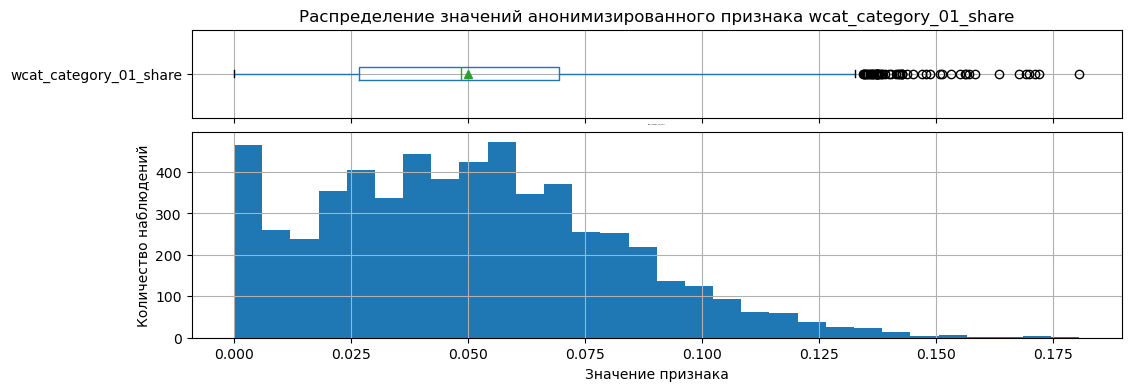

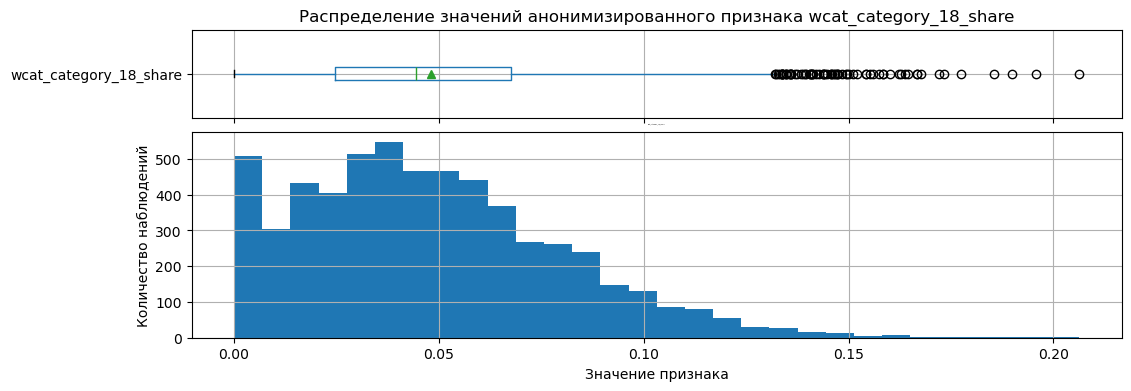

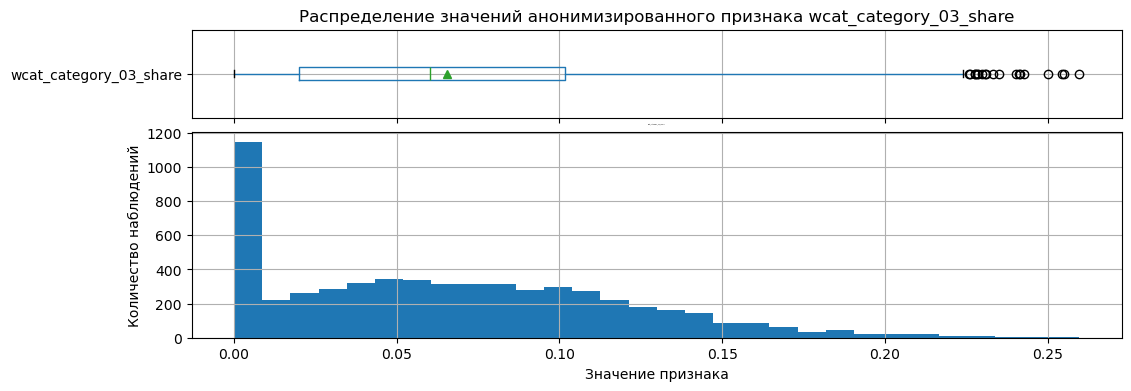

In [61]:
for feat in df[df.select_dtypes(include=['number']).columns].sample(n = 3, axis=1):
    combo_graph(df, feat, f'Распределение значений анонимизированного признака {feat}', 'Значение признака', 'Количество наблюдений')

Несмотря на то, что в целом распределения значений признаков действительно по большей части относительно равномерны, присутствуют также и отдельные случаи, где наблюдаются выбросы с лево- и право- сторонней ассиметрией. Также нужно учесть, что масштаб значений местами отличается - например, количество сессий против доли за категорию, перед началом обучения нелишним будет выполнить масштабирование данных. С учётом наличия выбросов в отдельных признаках, предлагается проводить масштабирование методом стандартизации.

### Корреляция

Теперь рассмотрим корреляции между данными и визуализируем матрицу.

In [62]:
def columns_post_process(data):
    return data.rename(columns=lambda x: x.split('__', 1)[-1])

Навскидку, среди производных признаков к непрерывным можно отнести все значения долей количества сессий в рамках комбинации категориальных признаков, однако будем считать, что непрерывным для построения матрицы корреляций будем считать признак с количеством уникальных значений больше 100.

In [63]:
continuous_features = []

print(f'{"столбец":<30} {"уникальных значений":>20}')

for column in df.columns:
    if df[column].nunique() > 100:
        continuous_features.append(column)
        print(f'{column:<30} {df[column].nunique():>20}')

столбец                         уникальных значений
user_id                                        5826
dayt_вечер_share                               2744
dayt_день_share                                2688
dayt_ночь_share                                1974
dayt_утро_share                                2508
wcat_category_17_share                         2034
wcat_category_19_share                         2107
wcat_category_18_share                         2125
wcat_category_20_share                         2057
wcat_category_05_share                         2175
wcat_category_12_share                         2093
wcat_category_03_share                         2393
wcat_category_15_share                         2029
wcat_category_10_share                         2054
wcat_category_06_share                         2100
wcat_category_04_share                         2049
wcat_category_09_share                         2089
wcat_category_01_share                         2110
wcat_categor

Предположение о принадлежности признаков долей к непрерывным поодтверждается, но исключим из этого списка явно категориальный wcat_dow_dayt_top с большим числом комбинаций значений и идентификатор user_id, который всё равно не будет участвовать в построении матрицы.

In [64]:
continuous_features = list(set(continuous_features) - set(['user_id', 'wcat_dow_dayt_top']))
#print(continuous_features)

In [65]:
corr_matrix = df.drop(columns='user_id').phik_matrix(interval_cols=continuous_features)

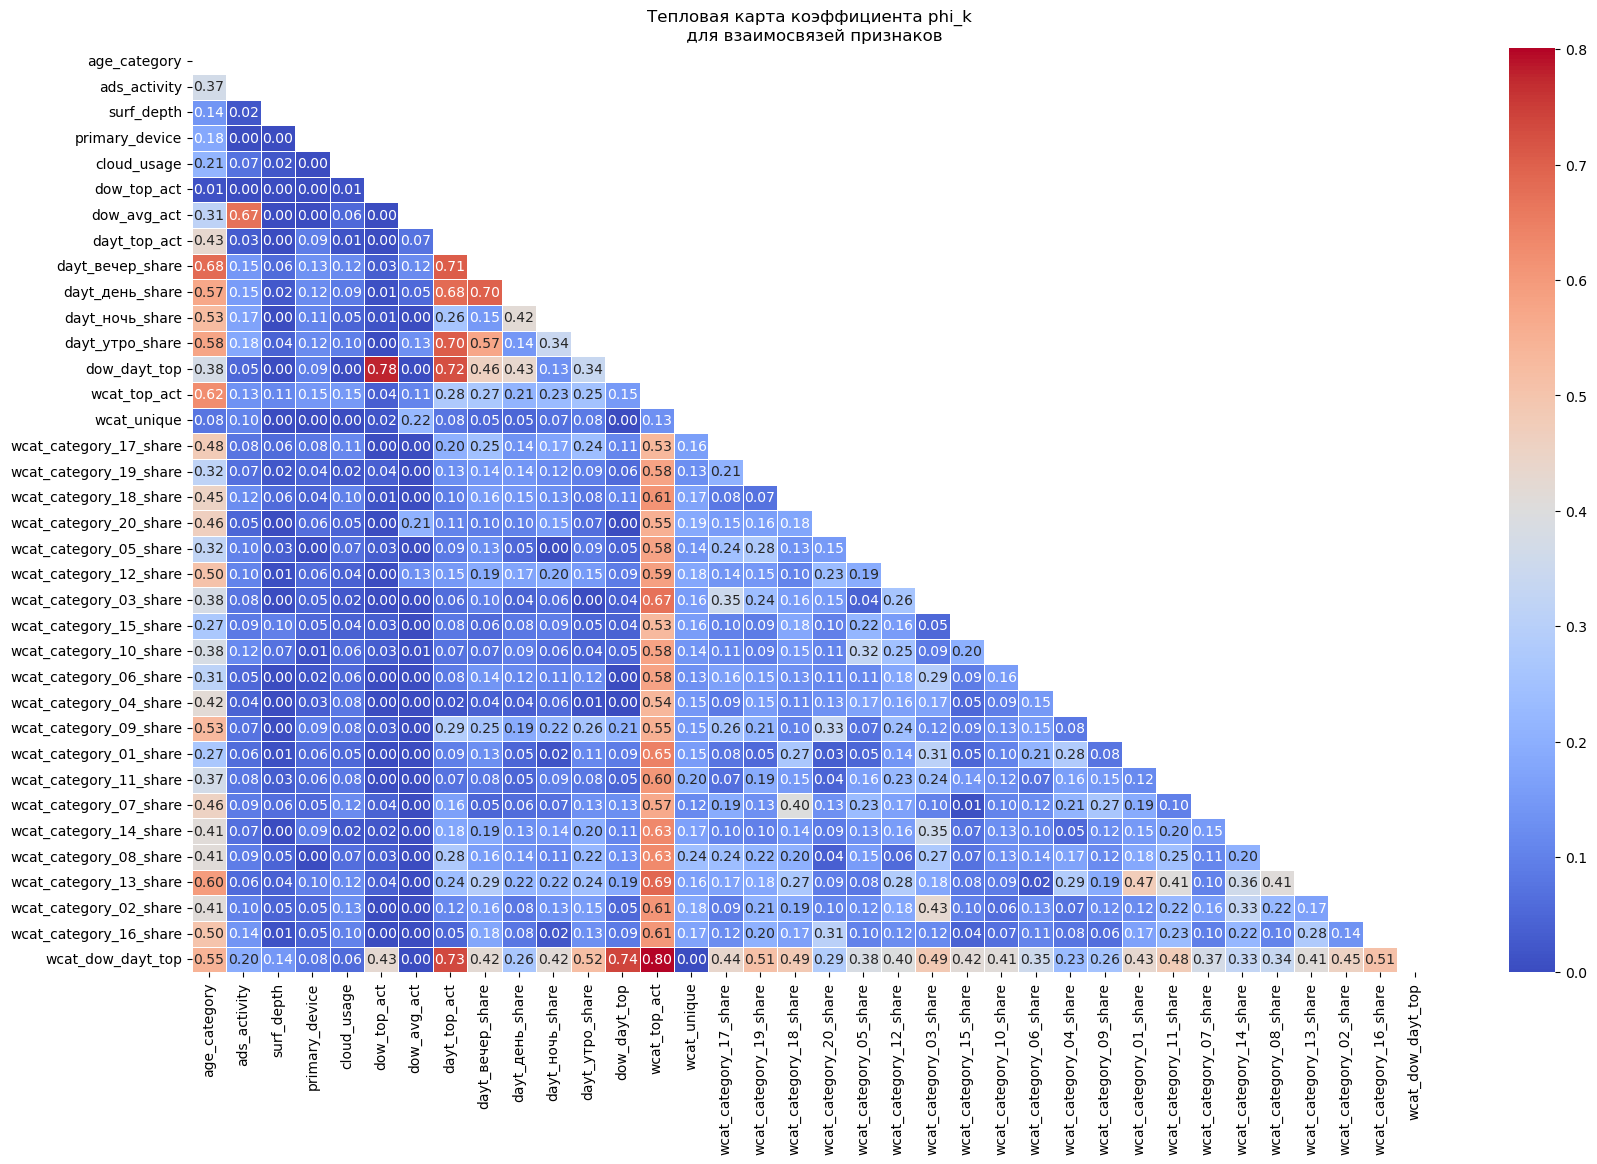

In [66]:
# Строим тепловую карту
plt.figure(figsize=(20, 12))

# Создаем маску для скрытия верхнего треугольника
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

sns.heatmap(corr_matrix,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            mask=mask,       # Применяем маску
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5#, # Форматируем линию между ячейками карты
#            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для взаимосвязей признаков')

# Выводим график
plt.show()

На данном этапе из визуализации phik-матрицы нельзя однозначно выбрать признаки, которые сильно кореллируют с целевой переменной, хотя в визуализации явно выделяется несколько производных признаков с высокими коэффициентами корреляции, что подтверждает правильность логики их создания. Также среди производных признаков видны достаточно сильные взаимосвязи - значения коэффициентов колеблются от 0.5 до 0.8, что указывает на потенциальную избыточность представленной информации и объясняется их частично пересекающимся смысловым наполнением. Однако, в связи с тем, что отбор наиболее важных признаков будет проводиться отдельным шагом, то пока просто отметим этот факт без изменения структуры датафрейма, т.к. явно коллинеарных - коэффициент корреляции >= 0.9, признаков не наблюдается, а значит можно сделать предварительный вывод, что данные готовы к дальнейшей работе.

Также для большей наглядности отсортируем коэффициенты корреляции с целевой переменной по убыванию и получим ТОП-5 наиболее значимых признаков с точки зрения phik-матрицы.

In [67]:
corr_matrix['age_category'].drop(labels=['age_category']).abs().sort_values(ascending=False).head()

dayt_вечер_share          0.682386
wcat_top_act              0.624123
wcat_category_13_share    0.595197
dayt_утро_share           0.576593
dayt_день_share           0.569928
Name: age_category, dtype: float64

### Выводы по EDA

До начала обработки подготовленная витрина профилей пользовательской активности содержит записи для 5826 уникальных идентификторов, каждая строка состоит из 37 столбцов, два из которых - служебные. Четыре категориальных признака попали в витрину напрямую из смежных справочников, но большая часть является производной от данных посещений сайтов. 

В датасете нет полных дубликатов - они были удалены при подготовке витрины данных, пропуски в объёме до 5% присутствуют в оригинальных категориальных признаках.

При анализе количества уникальных значений для категориальных признаов были составлены списки столбцов cols_cat_onehot и cols_cat_target для кодирования с помощью OneHotEncoder и TargetEncoder соответственно.

При составлении комбинированных признаков было выяснено, что данные в логе посещений представлены за 2 недели ноября 2025 года, поэтому было решено преобразовать дату в день недели, именно этот признак использовался для формирования производных значений. При составлении витрины и заполнении долей активности в разрезе категорий было решено заполнить пропущенные значения нулями, т.к. это явно показывает отсутствие активности в соответствующем сегменте.

Все числовые признаки являются производными, отличие их средних значений от медианы колеблется в пределах процента, поэтому было принято решение считать распределения значений равномерными. В связи с тем, что масштаб значений отличается, перед началом обучения нужно будет выполнить выполнить масштабирование данных методом мин-макс.

Перед началом анализа корреляций на отдельном датафрейме было выполнено кодирование категориальных признаков способами OneHotEncoder и TargetEncoder с делением категориальных признаков на соответствующие подгруппы по граничному значению в 10 уникальных значений. После визуализации корреляционной матрицы появилась возможность явно выделить некоторые производные признаки с высокими коффициентами, что подтверждает правильность логики их создания. Среди производных признаков были отмечены достаточно сильные взаимосвязи - значения коэффициентов колеблются от 0.5 до 0.8, что указывает на потенциальную избыточность представленной информации и объясняется частично пересекающимся смысловым наполнением этих признаков. В связи с тем, что явно коллинеарных - коэффициент корреляции >= 0.9, признаков не выявлено, было решено не вносить изменения в структуру витрины на этом этапе, но выделить фильтрацию признаков в отдельный шаг.

Таким образом, основными шагами пайплайна предобработки будут кодирование категориальных признаков и масштабирование числовых значений.

## Разделение данных на выборки

### Разделение данных

In [68]:
# Разделяем данные на train и test в соотношении 80/20
X = df.drop(columns=['age_category'])
y = df['age_category']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y,
    random_state=RANDOM_SEED)

In [69]:
print(f'Размеры обучающей выборки {X_train_val.shape}')
print(f'Размеры тестовой выборки {X_test.shape}')

Размеры обучающей выборки (4660, 36)
Размеры тестовой выборки (1166, 36)


### Проверка разделения

Убедимся, что распределение целевой переменной сохранено в каждой выборке.

In [70]:
vc_or = df['age_category'].value_counts(normalize=True)
vc_tr = y_train_val.value_counts(normalize=True)
vc_ts = y_test.value_counts(normalize=True)

pd.concat([vc_or, vc_tr, vc_ts], axis=1)

,proportion,proportion,proportion
age_category,,,
4,0.303124,0.303219,0.302744
2,0.246996,0.246996,0.246998
3,0.215242,0.215236,0.215266
0,0.146413,0.146352,0.146655
1,0.088225,0.088197,0.088336


Видно, что отличия процентного соотношения долей классов целевой переменной при делении исходных данных на выборки колеблются в пределах погрешности, сохраняя общий характер.

## Предобработка данных

### Числовые признаки

На этапе анализа данных пропусков обнаружено не было, однако наличие выбросов требует провести масштабирование данных.

In [71]:
cols_num = X_train_val.select_dtypes(include=['number']).columns
print(cols_num)

Index(['dow_avg_act', 'dayt_вечер_share', 'dayt_день_share', 'dayt_ночь_share',
       'dayt_утро_share', 'wcat_unique', 'wcat_category_17_share',
       'wcat_category_19_share', 'wcat_category_18_share',
       'wcat_category_20_share', 'wcat_category_05_share',
       'wcat_category_12_share', 'wcat_category_03_share',
       'wcat_category_15_share', 'wcat_category_10_share',
       'wcat_category_06_share', 'wcat_category_04_share',
       'wcat_category_09_share', 'wcat_category_01_share',
       'wcat_category_11_share', 'wcat_category_07_share',
       'wcat_category_14_share', 'wcat_category_08_share',
       'wcat_category_13_share', 'wcat_category_02_share',
       'wcat_category_16_share'],
      dtype='object')


In [72]:
num_ct = ColumnTransformer(
    transformers=[
#        ('scaler_std', MinMaxScaler(), cols_num)
        ('scaler_std', StandardScaler(), cols_num)
    ],
    remainder='passthrough'
)
num_ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler_std', StandardScaler(),
                                 Index(['dow_avg_act', 'dayt_вечер_share', 'dayt_день_share', 'dayt_ночь_share',
       'dayt_утро_share', 'wcat_unique', 'wcat_category_17_share',
       'wcat_category_19_share', 'wcat_category_18_share',
       'wcat_category_20_share', 'wcat_category_05_share',
       'wcat_category_12_share', 'wcat...hare',
       'wcat_category_15_share', 'wcat_category_10_share',
       'wcat_category_06_share', 'wcat_category_04_share',
       'wcat_category_09_share', 'wcat_category_01_share',
       'wcat_category_11_share', 'wcat_category_07_share',
       'wcat_category_14_share', 'wcat_category_08_share',
       'wcat_category_13_share', 'wcat_category_02_share',
       'wcat_category_16_share'],
      dtype='object'))])

С помощью декларированной на этапе анализа корреляций функции выделения оригинального названия признака после трансформации, создадим пайплайн предобработки числовых признаков.

In [73]:
num_prep = Pipeline(steps=[
    ('scaler_mnm', num_ct),
    ('scaler_post', FunctionTransformer(func=columns_post_process, validate=False))
])
#num_prep.fit_transform(X_train_val, y_train_val).head()

### Категориальные признаки

В связи с тем, что с момента построения списков признаков для кодирования категорий с учётом количества уникальных значений в структуре данных изменений не произошло, используем эти списки для создания пайплайна предобработки.

Вспомним, что на этапе EDA в исходных категориальных признаках было вявлено небольшое - до 5 процентов, количество пропусков и было решено заполнить такие пропуски наиболее частыми значениями.

In [74]:
cat_nan = df.columns[df.isna().any()].tolist()
print(cat_nan)
print(cols_cat_onehot)
print(cols_cat_target)

['ads_activity', 'surf_depth', 'primary_device', 'cloud_usage']
['ads_activity', 'surf_depth', 'primary_device', 'cloud_usage', 'dow_top_act', 'dayt_top_act']
['dow_dayt_top', 'wcat_top_act', 'wcat_dow_dayt_top']


В связи с тем, что ColumnTransformer не передаёт результаты от шага к шагу, тогда как нам требуется сначала заполнить пропуски, а только потом закодировать те же самые признаки через OneHotEncoder, хотя это и частный случай, создадим отдельные трансформеры для такой обработки после чего объединим их в один пайплайн для категориальных признаков.

In [75]:
imp_ct = ColumnTransformer(
    transformers=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_nan)
    ],
    remainder='passthrough'
)
imp_ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['ads_activity', 'surf_depth',
                                  'primary_device', 'cloud_usage'])])

In [76]:
cat_ct = ColumnTransformer(
    transformers=[
        ('cat_onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cols_cat_onehot),
        ('enc_target', TargetEncoder(), cols_cat_target)
    ],
    remainder='passthrough'
)
cat_ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['ads_activity', 'surf_depth',
                                  'primary_device', 'cloud_usage',
                                  'dow_top_act', 'dayt_top_act']),
                                ('enc_target', TargetEncoder(),
                                 ['dow_dayt_top', 'wcat_top_act',
                                  'wcat_dow_dayt_top'])])

С помощью декларированной на этапе анализа корреляций функции выделения названия оригинального признака после трансформации, создадим пайплайн предобработки категориальных признаков.

In [77]:
cat_prep = Pipeline(steps=[
    ('cat_imputer', imp_ct),
    ('cat_imp_post', FunctionTransformer(func=columns_post_process, validate=False)),
    ('cat_encoder', cat_ct),
    ('cat_enc_post', FunctionTransformer(func=columns_post_process, validate=False))
])
#cat_prep.fit_transform(X_train_val, y_train_val).head()

### Итоговый пайплайн предобработки

С учётом того, что идентификатор строки не был удалён на этапе подготовки данных и послужил хорошим индикатором при разделении на выборки, не позволяя смешивать данные разных пользователей, нужно создать и использовать функцию по его удалению в итоговом пайплайне предобработки.

In [78]:
def drop_id(data):
    return data.drop(columns=['user_id'])

In [79]:
pipeline_prep = Pipeline(steps=[
    ('drop_id', FunctionTransformer(func=drop_id, validate=False)),
    ('num_prep', num_prep),
    ('cat_prep', cat_prep)
])

## Обучение и оценка базовой модели

### Параметры кросс-валидации

Настроим базовые параметры кросс-валидации и создадим объект StratifiedKFold.

In [80]:
N_FOLDS = 5

scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

# Настройка кросс-валидации
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

Реализуем функции запуска кросс-валидации и добавления метрик в датафрейм результатов для упрощения дальнейшей работы.

In [81]:
def do_cv(name, pipeline, X_cv=X_train_val, y_cv=y_train_val):
    cv_results = cross_validate(
        estimator=pipeline,                # модель или pipeline
        X=X_cv,                            # признаки
        y=y_cv,                            # целевая переменная
        scoring=scoring,                   # список метрик
        cv=kfold,                          # стратегия разбиения
#       return_train_score = True,         # расчёт качества на трейне
#       return_estimator = True,           # сохранение обученных экземпляров модели
        n_jobs=-1 )

    return {'Name': name,
            'F1': cv_results["test_f1_macro"].mean(),
            'Precision': cv_results["test_precision_macro"].mean(),
            'Recall': cv_results["test_recall_macro"].mean()
           }

def update_metrics(name, pipeline, X_cv=X_train_val, y_cv=y_train_val, do_print=True):
    metrics.loc[len(metrics)] = do_cv(name, pipeline, X_cv, y_cv)

    if do_print == True:
        print('Результаты обучения моделей (средние значения):\n')
        print(metrics)

metrics = pd.DataFrame(columns=['Name', 'F1', 'Precision', 'Recall'])

### Обучение DummyClassifier

Модель DummyClassifier нативно умеет работать с многоклассоовй классификацией, учитывая количество классов целевой переменной.

In [82]:
pipeline_base = Pipeline(steps=[
    ('classifier', DummyClassifier(strategy='stratified', random_state=RANDOM_SEED))
])

In [83]:
update_metrics(f'{"Dummy Classifier":<20} Train', pipeline_base)

Результаты обучения моделей (средние значения):

                         Name        F1  Precision    Recall
0  Dummy Classifier     Train  0.194949    0.19498  0.195491


### Обучение LogisticRegression

В качестве базовой модели логистической регрессии испольуем параметры по умолчанию C=1.0, penalty='l2' (Ridge).

В sklearn начиная с версии 1.5 параметр `multi_class` удалён, теперь линейная регрессия принимает решение о выборе нужного алгоритма классификации на основании количества классов целевой переменной самостоятельно.

In [84]:
pipeline_logreg = Pipeline(steps=[
    ('preprocessing', pipeline_prep),
    ('classifier', LogisticRegression(
                        solver='lbfgs',
                        random_state=RANDOM_SEED))
])

In [85]:
update_metrics(f'{"LogReg":<20} Train', pipeline_logreg)

Результаты обучения моделей (средние значения):

                         Name        F1  Precision    Recall
0  Dummy Classifier     Train  0.194949   0.194980  0.195491
1  LogReg               Train  0.811095   0.815957  0.807704


Качество модели многоклассовой логистической регрессии значительно выросло по сравнению с константной моделью.

### Обучение SVC

In [86]:
pipeline_svc = Pipeline(steps=[
    ('preprocessing', pipeline_prep),
    ('classifier', SVC(kernel='linear', probability=False, max_iter=500, random_state=RANDOM_SEED))
])

In [87]:
update_metrics(f'{"SVC (linear)":<20} Train', pipeline_svc)

Результаты обучения моделей (средние значения):

                         Name        F1  Precision    Recall
0  Dummy Classifier     Train  0.194949   0.194980  0.195491
1  LogReg               Train  0.811095   0.815957  0.807704
2  SVC (linear)         Train  0.697388   0.696984  0.702265


Модель, основанная на опорных векторах, даже с линейным ядром и прочими параметрами по умолчанию - в этом случае используется подход OvO, показывает хорошие, но более низкие значения метрик классификации по сравнению с линейной регрессией.

### Сравнение базовых моделей

Сравнение метрик качества, собранных на разных моделях, позволяет увидеть, что LogisticRegression и SVM показывают значительно лучшие результаты по сравнению с DummyClassifier, причём SVM даёт хорошие результаты даже с линейным ядром на прочих настройках по умолчанию. Имеет смысл провести фильтрацию признаков после чего выполнить подбор гиперпараметров для моделей LogisticRegression и SVC с целью улучшения качества моделей.

## Отбор признаков

Применим пайплайн для предобработки тренировочной выборки, чтобы получить промежуточное состояние данных для использования в последующих экспериментах.

In [88]:
X_train = pipeline_prep.fit_transform(X_train_val, y_train_val)

### Отбор по коэффициенту корреляции

Посчитаем корреляцию каждого из признаков тренировочной выборки с целевой переменной и выведем список коэффициентов корреляции в порядке убывания их абсолютного значения.

In [89]:
X_train_corr = pd.DataFrame(round(X_train.corrwith(y_train_val).abs(), 4))
X_train_corr.sort_values(by=0, ascending=False)

,0
dayt_вечер_share,0.5989
dayt_top_act_день,0.4992
dayt_день_share,0.4943
dayt_утро_share,0.4905
dayt_ночь_share,0.4778
wcat_category_09_share,0.4280
wcat_category_13_share,0.4215
wcat_top_act_4,0.3777
dow_dayt_top_4,0.3758
dow_dayt_top_0,0.3736


In [90]:
X_train_corr.describe()

,0
count,59.000000
mean,0.180551
std,0.162982
min,0.000200
25%,0.033050
50%,0.126700
75%,0.304650
max,0.598900


Предлагается принять нижнюю границу первого квартиля распределения значений модулей коэффициентов корреляции в качестве фильтра, оставив таким образом 75% признаков.

In [91]:
corr_tolr = X_train_corr.describe().T['25%'][0]

In [92]:
cols_major_df = X_train_corr[X_train_corr[0] >= corr_tolr]
cols_major_df.sort_values(by=0, ascending=False).head()

,0
dayt_вечер_share,0.5989
dayt_top_act_день,0.4992
dayt_день_share,0.4943
dayt_утро_share,0.4905
dayt_ночь_share,0.4778


Составим список признаков для дальнейшего использования.

In [93]:
major_features_corr = cols_major_df.sort_values(by=0, ascending=False).T.columns
print(major_features_corr)

Index(['dayt_вечер_share', 'dayt_top_act_день', 'dayt_день_share',
       'dayt_утро_share', 'dayt_ночь_share', 'wcat_category_09_share',
       'wcat_category_13_share', 'wcat_top_act_4', 'dow_dayt_top_4',
       'dow_dayt_top_0', 'wcat_category_17_share', 'wcat_top_act_1',
       'dow_dayt_top_2', 'wcat_category_12_share', 'wcat_top_act_0',
       'wcat_category_14_share', 'dow_dayt_top_1', 'dow_dayt_top_3',
       'wcat_dow_dayt_top_4', 'wcat_category_19_share',
       'wcat_category_20_share', 'wcat_category_02_share', 'wcat_top_act_2',
       'wcat_dow_dayt_top_0', 'primary_device_смартфон',
       'wcat_category_11_share', 'wcat_category_06_share',
       'wcat_category_10_share', 'wcat_category_18_share',
       'wcat_category_15_share', 'wcat_top_act_3', 'wcat_dow_dayt_top_2',
       'wcat_category_08_share', 'primary_device_ноутбук',
       'wcat_dow_dayt_top_1', 'wcat_unique', 'wcat_category_03_share',
       'wcat_category_05_share', 'primary_device_планшет',
       'ads_act

### Признаки с низкой вариативностью значений

Отберём признаки с очень низкой вариацией с помощью VarianceThreshold на основании данных, прошедших предобработку, т.е. масштабирование и кодирование категориальных признаков.

In [94]:
vs_lowvar = VarianceThreshold(threshold=0.1)
vs_lowvar.fit(X_train)

low_variance_columns = [col for col, keep in zip(X_train.columns, vs_lowvar.get_support()) if not keep] 
print(low_variance_columns)

['ads_activity_очень часто', 'primary_device_планшет', 'dayt_top_act_утро', 'dow_dayt_top_0', 'dow_dayt_top_1', 'dow_dayt_top_2', 'dow_dayt_top_3', 'dow_dayt_top_4', 'wcat_top_act_0', 'wcat_top_act_1', 'wcat_top_act_2', 'wcat_top_act_3', 'wcat_top_act_4', 'wcat_dow_dayt_top_0', 'wcat_dow_dayt_top_1', 'wcat_dow_dayt_top_2', 'wcat_dow_dayt_top_3', 'wcat_dow_dayt_top_4']


Исключим признаки с низкой вариативностью из списка признаков с высокими коэффицентами корреляции.

In [95]:
major_features = list(set(major_features_corr) - set(low_variance_columns))
print(f'{major_features}, количество = {len(major_features)}')

['dayt_ночь_share', 'primary_device_смартфон', 'wcat_category_18_share', 'ads_activity_умеренно', 'wcat_category_06_share', 'dayt_утро_share', 'dayt_вечер_share', 'wcat_category_17_share', 'wcat_category_20_share', 'wcat_category_03_share', 'wcat_category_05_share', 'dayt_top_act_день', 'wcat_category_11_share', 'wcat_category_15_share', 'wcat_unique', 'wcat_category_12_share', 'wcat_category_10_share', 'wcat_category_08_share', 'wcat_category_19_share', 'dayt_день_share', 'wcat_category_02_share', 'wcat_category_13_share', 'wcat_category_14_share', 'primary_device_ноутбук', 'wcat_category_04_share', 'cloud_usage_True', 'wcat_category_09_share'], количество = 27


### Отбор с помощью методов-обёрток

In [96]:
#X_train.info()

Применим сбалансированный алгоритм рекурсивного исключения признаков, в качестве модели оценки используем логистическую регрессию. Определим количество признаков для поиска равным трети количества столбцов тренировочной выборки.

In [97]:
X_train.shape

(4660, 59)

In [98]:
#num_features_rfe = len(major_features)
num_features_rfe = 0.33

rfe_selector = RFE(estimator=LogisticRegression(solver='lbfgs'),
                   n_features_to_select=num_features_rfe,
                   step=1,          # Количество признаков для удаления на каждой итерации (по умолчанию 1)
                   verbose=0)       # Уровень детализации вывода

# Обучаем RFE на обучающих данных
rfe_selector.fit(X_train, y_train_val)

rfe_features = X_train.columns[rfe_selector.support_].tolist()
print(f'\nВыбранные признаки RFE ({num_features_rfe}): {rfe_features}')


Выбранные признаки RFE (0.33): ['primary_device_планшет', 'primary_device_смартфон', 'dow_dayt_top_4', 'wcat_top_act_2', 'wcat_top_act_3', 'wcat_top_act_4', 'wcat_dow_dayt_top_1', 'dayt_вечер_share', 'dayt_ночь_share', 'wcat_category_17_share', 'wcat_category_18_share', 'wcat_category_20_share', 'wcat_category_12_share', 'wcat_category_03_share', 'wcat_category_15_share', 'wcat_category_10_share', 'wcat_category_09_share', 'wcat_category_13_share', 'wcat_category_16_share']


### Финальный набор признаков

Составим финальный набор признаков, объединив списки признаков с наибольшими значениями коэффициентов корреляции, за исключением признаков с низкой вариативностью значений, и признаков, найденных с помощью метода-обёртки для рекурсивного исключения признаков.

In [99]:
major_features_final = list(set(major_features + rfe_features))
major_features_final.sort()
print(f'{major_features_final}, количество = {len(major_features_final)}')

['ads_activity_умеренно', 'cloud_usage_True', 'dayt_top_act_день', 'dayt_вечер_share', 'dayt_день_share', 'dayt_ночь_share', 'dayt_утро_share', 'dow_dayt_top_4', 'primary_device_ноутбук', 'primary_device_планшет', 'primary_device_смартфон', 'wcat_category_02_share', 'wcat_category_03_share', 'wcat_category_04_share', 'wcat_category_05_share', 'wcat_category_06_share', 'wcat_category_08_share', 'wcat_category_09_share', 'wcat_category_10_share', 'wcat_category_11_share', 'wcat_category_12_share', 'wcat_category_13_share', 'wcat_category_14_share', 'wcat_category_15_share', 'wcat_category_16_share', 'wcat_category_17_share', 'wcat_category_18_share', 'wcat_category_19_share', 'wcat_category_20_share', 'wcat_dow_dayt_top_1', 'wcat_top_act_2', 'wcat_top_act_3', 'wcat_top_act_4', 'wcat_unique'], количество = 34


### Дополнение пайплайна предобработки 

Дополним пайплайн предобработки логикой отбора лучших признаков.

In [100]:
def filter_features(data):
    return data[major_features_final]

In [101]:
pipeline_prep_major = Pipeline(steps=[
    ('prep_main', pipeline_prep),
    ('flt_feat', FunctionTransformer(func=filter_features, validate=False)),
])

## Подбор гиперпараметров моделей

### Определим сетку гиперпараметров

Проверим возможность улучшения качества моделей путём перебора гиперпараметров для LogisticRegression и SVC с оптимизацией по F1:
* С, контролирующий величину штрафа за большие веса (меньше значение - жёстче ограничения)
* специально для LogisticRegression с ядром lbfgs не будет отдельных манипуляций, т.к. для этого ядра поддерживается только вариант penalty = l2 (Ridge)
* специально для SVC проверим использование нелинейных ядер rbf и sigmoid, а также параметр gamma, определяющий радиус влияния отдельных точек (меньше значение - точка влияет на большие области, границы более плавные, модель менее гибкая, большое - точка влияет только на ближайших соседей, граница сильно изгибается, есть риск переобучения)

In [102]:
param_grid = [
    # Parameters for Logistic Regression
    {
        'classifier': [LogisticRegression(solver='lbfgs', random_state=RANDOM_SEED)], # 'liblinear' solver supports l1/l2
        'classifier__C': np.logspace(-3, 3, 7), # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    # Parameters for SVM
    {
        'classifier': [SVC(probability=False, max_iter=500, random_state=RANDOM_SEED)],
        'classifier__C': np.logspace(-3, 3, 7), # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
        'classifier__gamma': np.logspace(-1, 1, 3) #[0.1, 1, 10],
    }
]

### Применим поиск по сетке

В связи с тем, что вариантов перебора будет относительно немного, применим GridSearchCV, в качестве основной метрики оптимизации используем F1. Также создадим для поиска отдельный пайплайн, учитывающий отобранные признаки.

In [103]:
pipeline_logreg_major = Pipeline(steps=[
    ('preprocessing', pipeline_prep_major),
    ('classifier', LogisticRegression(solver='lbfgs', random_state=RANDOM_SEED))
])

In [104]:
grid_search = GridSearchCV(
    estimator=pipeline_logreg_major, # атрибут classifier будет заменён экземпляром нужной модели при переборе параметров
    param_grid=param_grid,
    cv=kfold,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

In [105]:
grid_search.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=189, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('prep_main',
                                                         Pipeline(steps=[('drop_id',
                                                                          FunctionTransformer(func=<function drop_id at 0x000001CA3F267600>)),
                                                                         ('num_prep',
                                                                          Pipeline(steps=[('scaler_mnm',
                                                                                           ColumnTransformer(remainder='passthrough',
                                                                                                             transformers=[('scaler_std',...
             param_grid=[{'classifier': [LogisticRegression(random_state=189)],
                          'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                         {'classifier': [SVC(max_iter=500, random_state=189)],
                          'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'classifier__gamma': array([ 0.1,  1. , 10. ]),
                          'classifier__kernel': ['linear', 'rbf', 'sigmoid']}],
             scoring='f1_macro', verbose=1)

### Лучший результат

In [106]:
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': np.float64(1.0), 'classifier__gamma': np.float64(0.1), 'classifier__kernel': 'rbf'}
0.8797633160664029


### Топ-10 лучших конфигураций

In [107]:
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head(10)\
          [['params', 'mean_test_score', 'std_test_score']])

,params,mean_test_score,std_test_score
35,"{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': 1.0, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}",0.879763,0.005300
53,"{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': 100.0, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}",0.875589,0.007906
62,"{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': 1000.0, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}",0.875216,0.007208
44,"{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': 10.0, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}",0.875216,0.007097
31,"{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': 0.1, 'classifier__gamma': 10.0, 'classifier__kernel': 'linear'}",0.805388,0.010087
6,"{'classifier': LogisticRegression(random_state=189), 'classifier__C': 1000.0}",0.805156,0.011119
5,"{'classifier': LogisticRegression(random_state=189), 'classifier__C': 100.0}",0.804980,0.011046
3,"{'classifier': LogisticRegression(random_state=189), 'classifier__C': 1.0}",0.804644,0.008965
25,"{'classifier': SVC(max_iter=500, random_state=189), 'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'linear'}",0.804447,0.008629
4,"{'classifier': LogisticRegression(random_state=189), 'classifier__C': 10.0}",0.803816,0.011281


## Финальная модель

### Оценка финальной модели

Лучшая модель по результатам поиска уже обучена и хранится в переменной best_model, поэтому сразу выполним предсказание на тестовой выборке и оценим качество с помощью метрики F1, а также сформируем classification_report по результатам предсказаний.

In [108]:
y_pred_best = best_model.predict(X_test)
print(f"F1 лучшей модели {round(f1_score(y_test, y_pred_best, average='macro'), 4)}")
print(classification_report(y_test, y_pred_best))

F1 лучшей модели 0.9024
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       171
           1       0.91      0.75      0.82       103
           2       0.90      0.92      0.91       288
           3       0.93      0.91      0.92       251
           4       0.92      0.97      0.94       353

    accuracy                           0.92      1166
   macro avg       0.92      0.89      0.90      1166
weighted avg       0.92      0.92      0.92      1166



Несмотря на отличия в количестве объектов разных классов, лучшая модель на тестовой выборке показывает высокие результаты, хорошо предсказывая почти все классы хотя и показывает снижение точности предсказаний на группе 1 (18-25 лет), доля которой в общем распределении значений целевой переменной составляла порядка 9 процентов, что может быть объяснено недостаточным количеством примеров для соответствующей группы в исходных данных.

### Важные признаки финальной модели

Рассмотрим самые важные признаки лучшей модели - это будут коэффициенты с максимальными значениями по модулю. Рассмотрим ТОП-10 таких коэффициентов.

In [109]:
try:
    pd.DataFrame(best_model.named_steps['classifier'].coef_, columns=major_features_final).T.abs().sort_values(by=0, ascending=False).head(10)
except:
    # лучшая модель SVM с нелинейным ядром, в этом случае доступ к коэффицентам осуществляется через опорные вектора
    #print(f'{"Количество опорных векторов на класс":<39}: {best_model.named_steps['classifier'].n_support_}')
    #print(f'{"Размерности опорных векторов":<39}: {best_model.named_steps['classifier'].support_vectors_.shape}')
    #print(f'{"Размерности двойных коэффициентов":<39}: {best_model.named_steps['classifier'].dual_coef_.shape}')
    #print(f'{"Смещение":<39}: {best_model.named_steps['classifier'].intercept_}')
    df_svm_res = pd.DataFrame(columns=['feature', 'coefficient'])
    for name, value in zip(major_features_final, best_model.named_steps['classifier'].support_vectors_[0]):
        df_svm_res.loc[len(df_svm_res)] = {'feature': name, 'coefficient': value}
    df_svm_res['coefficient'] = df_svm_res['coefficient'].abs()
    display(df_svm_res.sort_values(by='coefficient', ascending=False).head(10))


,feature,coefficient
15,wcat_category_06_share,1.656384
24,wcat_category_16_share,1.518817
25,wcat_category_17_share,1.461231
18,wcat_category_10_share,1.263118
13,wcat_category_04_share,1.097261
4,dayt_день_share,1.069864
1,cloud_usage_True,1.000000
26,wcat_category_18_share,0.971989
11,wcat_category_02_share,0.824829
6,dayt_утро_share,0.765324


Из полученного списка видно, что для классификации пользователей по возрастным группам модель посчитала наиболее важными признаками доли посещений сайтов определённых категорий и распределение долей количества сессий по времени суток, а также ряд значений оригинальных категориальных признаков. Таким образом, зная частоту посещений и категории сайтов можно с большой вероятностью корректно определить возраст пользователя и предложить ему таргетированную рекламу, ориентированную на соответствующую аудиторию.

### Сравнение результатов моделей

In [110]:
update_metrics(f'{"Лучшая модель":<20} Train', best_model)

Результаты обучения моделей (средние значения):

                         Name        F1  Precision    Recall
0  Dummy Classifier     Train  0.194949   0.194980  0.195491
1  LogReg               Train  0.811095   0.815957  0.807704
2  SVC (linear)         Train  0.697388   0.696984  0.702265
3  Лучшая модель        Train  0.879960   0.892953  0.871348


In [111]:
def update_metrics_pred(name, y_true, y_pred, do_print=True):
    metrics.loc[len(metrics)] = {
        'Name': name,
        'F1': f1_score(y_true, y_pred, average='macro'),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro') }

    if do_print == True:
        print('Результаты обучения моделей (средние значения):\n')
        print(metrics)

In [112]:
update_metrics_pred(f'{"Лучшая модель":<20} Test', y_test, y_pred_best)

Результаты обучения моделей (средние значения):

                         Name        F1  Precision    Recall
0  Dummy Classifier     Train  0.194949   0.194980  0.195491
1  LogReg               Train  0.811095   0.815957  0.807704
2  SVC (linear)         Train  0.697388   0.696984  0.702265
3  Лучшая модель        Train  0.879960   0.892953  0.871348
4   Лучшая модель        Test  0.902400   0.915811  0.892364


Лучшая модель на обучающей выборке показывает сопоставимо высокие результаты по сравнению с базовыми моделями, использовавшими полный список признаков, сохраняя паритет значений метрик в том числе и на тестовой выборке.

### Выводы

Качество итоговой модели значительно улучшилось по сравнению с базовой DummyClassifier, т.е. модели действительно удалось уловить закономерности в значениях признаков и предсказывать значение целевой переменной с высокой точностью.

Больше всего на вероятность корректного предсказания целевой переменной влияют доли посещений сайтов определённых категорий и распределение долей количества сессий по времени суток. Таким образом, зная частоту посещений и категории сайтов можно с большой вероятностью корректно определить возраст пользователя и предложить ему таргетированную рекламу, ориентированную на соответствующую аудиторию.

По общей оценке F1-меры, значение которой выше 0.8 и на обучающей, и тестовой выборках, с учётом выполнения исходного требования пл качеству модели (F1 > 0.75) её можно классифицировать как хорошую и рекомендовать к использованию в рабочем процессе.

## Подготовка артефактов модели для внедрения

### Сохранение модели

In [113]:
now_str = f'{datetime.now():%Y-%m-%d}'
model_f1_macro = round(metrics.iloc[len(metrics) - 1]['F1'] * 100, 2)
model_file = f"yeti_age_category_prediction_v{MODEL_VERSION}_{now_str}.pkl"

In [114]:
metadata = {
    'model_version': MODEL_VERSION,
    'training_date': now_str,
    'F1 macro': model_f1_macro,
    'features': major_features_final
}

joblib.dump({
    'model': best_model,
    'metadata': metadata
}, model_file)

['yeti_age_category_prediction_v1.0_2026-02-24.pkl']

### Проверка работоспособности загруженной модели

Проверяем сохранённую модель.

In [115]:
# Загружаем модель
loaded_model = joblib.load(model_file)['model']
y_pred_loaded = loaded_model.predict(X_test)

update_metrics_pred(f'{"Загруженная модель":<20} Test', y_test, y_pred_best)

Результаты обучения моделей (средние значения):

                         Name        F1  Precision    Recall
0  Dummy Classifier     Train  0.194949   0.194980  0.195491
1  LogReg               Train  0.811095   0.815957  0.807704
2  SVC (linear)         Train  0.697388   0.696984  0.702265
3  Лучшая модель        Train  0.879960   0.892953  0.871348
4   Лучшая модель        Test  0.902400   0.915811  0.892364
5   Загруженная модель   Test  0.902400   0.915811  0.892364


### Ссылка на проект на GitHub

https://github.com/easuvorov/yandexds_project_module3

## Выводы о результатах работы

В рамках работы над проектом по предсказанию возрастной группы пользователей были загружены данные из разных csv-файлов, для унификации процесса и облегчения поддержки проекта была создана функция `load_data()`, где можно централизованно вносить изменения в связанную логику.

После первичного анализа данных было принято решение о создании витрины профилей пользователей, включающей как существующие категориальные признаки, так и ряд производных признаков, созданных на основании лога посещений сайтов. Для унификации процесса и облегчения поддержки проекта была создана функция `get_visits_stats()`, где можно централизованно вносить изменения в связанную логику. После создания новых признаков названия столбцов были приведены к snake_case. Было выполнено объединение датасета с возрастными категориями пользователей с прочими бащовыми признаками, в результате этих действий был обнаружен ряд полных длубликатов, которые были удалены. После этого данные  были дополнены производными признаками. В результате получен датасет для 5826 уникальных идентификаторов пользователей, каждая строка которого состоит из 37 столбцов.

При анализе распределения классов целевой переменной было обнаружено, что большая часть данных представлена для трёх основных категорий: 56+ лет (около 30%), 26-40 лет (около 25%) и 41-55 лет (около 22%). Остальные категории значительно отличаются по процентному соотношению с долями ~15% (младше 18 лет) и ~9% (18-25 лет). Таким образом в целевой переменной наблюдается дисбаланс классов, один из классов - крайне редкий с долей всего в 9 процентов.

Дубликатов в витрине профилей обнаружено не было, пропуски присутствовали только в исходных категориальных признаках, их заполнение было отложено на этап предобработки.

Было выполнено стратифицированное разделение витрины профилей на обучающую + валидационную и тестовую выборки в соотношении 80 / 20. Проверка показала, что после деления соотношение классов целевой переменной не изменилоась.

Был составлен пайплайн предобработки для числовым и категориальных признаков. Были обучены три базовые модели - DummyClassifier, LogisticRegression и SVC, которые в рамках 5-фолдовой кросс-валидации показали хорошие результаты.

Была выполнена трансформация обучающей выборки с помощью пайплайна предобработки в отдельный датафрейм для отбора лучших признаков. Был выполнен отбор 75% признаков по коэффициенту корреляции с целевой переменной, из этого списка исключены признаки с низкой вариантивностью, после чего список был дополнен результатом работы метода рекурсивного исключения признаков с целевым количеством признаков порядка трети от количества признаков трансформированной обучающей выборки (65). В результате был получен список из 34 наиболее важных признаков.

Был выполнен подбор гиперпараметров для моделей логистической регресии и SVC, для обеих моделей итерировались параметры С, а для SVC - нелинейные ядра и параметр gamma. В результате лучшей была определена модель SVC с ядром rbf, C=10.0 и gamma=0.1. Лучшая модель показала более высокие результаты как на обучающей, так и на тестовой выборке. Качество итоговой модели значительно улучшилось по сравнению с базовой DummyClassifier, т.е. модели действительно удалось уловить закономерности в значениях признаков и предсказывать значение целевой переменной с высокой точностью.

По общей оценке F1-меры, значение которой выше 0.8 и на обучающей, и тестовой выборках, с учётом выполнения исходного требования по качеству оценки модели (F1 > 0.75) её можно классифицировать как хорошую и рекомендовать к использованию в рабочем процессе.